In [0]:
ki!pip install langdetect
import pandas as pd
from langdetect import detect
import numpy as np
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import words
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

In [0]:
#Download helpful lexicons and declare variables related to said lexicons
nltk.download('words')
nltk.download('stopwords')
wpt = nltk.WordPunctTokenizer()
words_ = words.words()
stop_words = nltk.corpus.stopwords.words('english')

ERROR! Session/line number was not unique in database. History logging moved to new session 59
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#load in Iranian twitter data that I (Travis McGary) uploaded to S3.
iranian_tweets_df = pd.read_csv('https://tjmcgary-cis4680.s3.amazonaws.com/International+twitter+data/iranian_tweets_csv_hashed.csv')
#append a column called Label onto the end with the value of "Iran"
iranian_tweets_df.insert(iranian_tweets_df.shape[1], "Label", 'Iran', allow_duplicates = True)
#grab only the tweet_text data and the label
iranian_tweets_df = iranian_tweets_df[(iranian_tweets_df['tweet_language'] == 'en') ][:][['tweet_text', 'Label']].sample(n=25000, random_state=1)


In [0]:
#load in Russian twitter data that I (Travis McGary) uploaded to S3.
russian_tweets_df = pd.read_csv('https://tjmcgary-cis4680.s3.amazonaws.com/International+twitter+data/russian_linked_tweets_csv_hashed.csv')
#append a column called Label onto the end with the value of "Russia"
russian_tweets_df.insert(russian_tweets_df.shape[1], "Label", 'Russia', allow_duplicates = True)
#grab only the tweet_text data and the label
russian_tweets_df = russian_tweets_df[(russian_tweets_df['tweet_language'] == 'en')][:][['tweet_text', 'Label']].sample(n=25000, random_state=1)
russian_tweets_df.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(25000, 2)

In [0]:
#load in UAE twitter data that I (Travis McGary) uploaded to S3.
UAE_tweets_df = pd.read_csv('https://tjmcgary-cis4680.s3.amazonaws.com/International+twitter+data/uae_082019_tweets_csv_hashed.csv')
#append a column called Label onto the end with the value of "UAE"
UAE_tweets_df.insert(UAE_tweets_df.shape[1], "Label", 'UAE', allow_duplicates = True)
#grab only the tweet_text data and the label
UAE_tweets_df = UAE_tweets_df[(UAE_tweets_df['tweet_language'] == 'en')][:][['tweet_text', 'Label']].sample(n=25000, random_state=1)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15,19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#load in verififed Human twitter data that I (Travis McGary) uploaded to S3.
human_tweets_df = pd.read_csv('https://tjmcgary-cis4680.s3.amazonaws.com/International+twitter+data/legitimate_users_tweets.txt', sep="\t", header=None)
human_tweets_df.columns = ["User ID", "Tweet ID", "tweet_text", "Time Stamp"]
#sample and reindex the data
human_tweets_df = human_tweets_df.sample(n=5000, random_state=1)
human_tweets_df = human_tweets_df.reset_index(drop=True)
#this dataset did not have a lang column so we will append it.
human_tweets_df['lang'] = None
#label the data as human data
human_tweets_df['Label'] = 'human'
human_tweets_df.head()

,User ID,Tweet ID,tweet_text,Time Stamp,lang,Label
0,21546037,5180397114,RT @lauralollipop: http://twitpic.com/n1i8q - ...,2009-10-26 14:18:36,None,human
1,69004147,5844025389,@spielerei8707 おはです。またもや夢わすれてます＾＾覚えてるうちに記録してくと...,2009-11-18 19:21:04,None,human
2,36913704,5605969255,online di kelas kewarganegaraan,2009-11-10 19:27:14,None,human
3,34736565,5898843955,@GeekyClean WooHoo Thank you,2009-11-20 14:02:17,None,human
4,67583523,5675928073,ただいま。のんびり立ち読みしてたらポメラ受け取りそこねたよ。,2009-11-13 03:58:27,None,human


In [0]:
def filter_english(data_frame):
  for row in data_frame.itertuples():
      try:
        #Try to detect the langauge of the tweet
        language = detect(row[3])
      except:
        #if it cannot detect english(most common with tweets whose content consists
        #soley of links) set the langage to error so it will be dropped.
        language = "error"
      #Set the langauge column for the row to the language detected.   
      data_frame.iat[row[0], 4] = language
  #drop any non-english, error, or retweets.
  return data_frame[data_frame['lang'] == 'en'][:][['tweet_text', 'Label']]

In [0]:
human_tweets_df = filter_english(human_tweets_df).reset_index(drop=True)
human_tweets_df

,tweet_text,Label
0,RT @lauralollipop: http://twitpic.com/n1i8q - ...,human
1,@GeekyClean WooHoo Thank you,human
2,business study+,human
3,Online Paralegal: Freelance/Contract Paralegal...,human
4,@AlexSilverman @laurafrantz if states would is...,human
...,...,...
2691,If u choose your girls carefully u won't have ...,human
2692,All Black lashes out over Twitter story: Neemi...,human
2693,http://www.youtube.com/watch?v=T-23IxXNs0E gaa...,human
2694,a long day of doing nothing but getting ready ...,human


In [0]:
#Append the three dataframes into one data frame (Essentially an SQL Union). 
#reset the index and drop the new index column so that the dataframe is easier to work with.
df = iranian_tweets_df.append([russian_tweets_df, UAE_tweets_df]).reset_index(drop=True)
df.head()

,tweet_text,Label
0,RT @DaysofPalestine: UK minister secretly met ...,Iran
1,Israeli Army Patrol Is Hit With IED Around Gaz...,Iran
2,RT @BoutiqueJalouze: Embellished Clutch Bag ht...,Iran
3,RT @Fintribune: #Iran National Tax Administrat...,Iran
4,@FranciscoFrankJ shame:ISIS’s representatives ...,Iran


In [0]:
#We need to decide what analysis we want to do next and what we are trying to discover in our data
#Clustering, sentiment analysis, LDA, Word2Vector, Nueral Nets, ect.
#Kelton suggested this article which looks like it has a lot of what we want to do: 
#https://www.sciencedirect.com/science/article/pii/S0925231218308798

In [0]:
#create df with only bot data
#get a sample of about 1% of the data as working with the entire set causes colab to crash
df = df.sample(n=200, random_state=4).reset_index(drop=True)
df.iloc[:]

,tweet_text,Label
0,The insane criminal attacks from #Houthis agai...,UAE
1,@iMahbuob hhhhhhhhhh w ana walhy 😂😂😂,UAE
2,"RT @MI_4_TRUMP: @Destinbeach22 Same here, on t...",Russia
3,RT @libertyfrontpr: A massive hurricane is abo...,Iran
4,Running on empty: Russia has less than three d...,Iran
...,...,...
195,"America, The Serial Arsonist https://t.co/H4hr...",Iran
196,"RT @MotivatedLiving: People will hate you, rat...",UAE
197,RT @libertyfrontp: Paris knife brawl between r...,Iran
198,RT @PopSci: What will we name the solar system...,UAE


In [0]:
#convert from Dataframe to array, also remove Label and is_retweet columns
corpus = np.array(df.drop(['Label'], axis=1)) 
#used to convert from multi-dimensional array to 1-dimension
corpus = corpus.ravel()
corpus

array(['The insane criminal attacks from #Houthis against service facilities such as the Mokha seaport want to create chaos, destruction, and death everywhere\n #Alhudaida #Yemen @giorgiozanchini',
       '@iMahbuob hhhhhhhhhh w ana walhy 😂😂😂',
       'RT @MI_4_TRUMP: @Destinbeach22 Same here, on twitter for Trump! Only for Trump! MAGA... I wish you well in your  efforts!!',
       'RT @libertyfrontpr: A massive hurricane is about to hit Texas—and Trump never put anyone in charge. #DonaldTrump #hurricaneharvey #Texas #P…',
       'Running on empty: Russia has less than three decades of oil remaining https://t.co/Hga7PNhdFT https://t.co/72KbcECvCt',
       'RT @Iranlandscape: #Iran #Iranlandscape Golestan Palace window and reflecting pool, #Tehran ,#MustSeeIran http://t.co/yyLyD2VABp http://t.c…',
       "RT @Partisangirl: The #FakeNewsMedia is telling you the #Syria-n people want #Trump to attack. Truth is they're blockading the UN office in…",
       'Attorney general @LorettaLynch co

In [0]:
#TF-IDF of the bot posts
#First we need to clean each document, make everything lower case, get rid of html tags, etc.
def normalize_document (doc):
    #lowercase and remove special characters\whitespace
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) #re.I ignore case sensitive, ASCII-only matching
    doc = doc.lower()
    doc = doc.strip()#remove extra whitespace
    soup = BeautifulSoup (doc,"html.parser")
    [s.extract() for s in soup (['iframe','script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'http\S+', '', stripped_text)#remove any links in the post
    doc = re.sub(r'[\r|\n|\r\n)]+', '\n', stripped_text)#remove html tags
    #tokenize document
    tokens = wpt.tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    #remove gibberish values left behind from removing urls
    filtered_tokens = [token for token in filtered_tokens if token in words_]
    #re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [0]:
#We take our normalize_document function and vectorize it
#this creates a new function, normalize_corpus that can work over our whole corpus.
normalize_corpus = np.vectorize(normalize_document)
#We normalize our corpus and assign it to a new variable, norm_corpus.
norm_corpus = normalize_corpus(corpus)
norm_corpus

array(['insane criminal service seaport want create chaos destruction death everywhere',
       'w ana', 'twitter trump trump wish well',
       'massive hurricane hit trump never put anyone charge p',
       'running empty russia less three oil',
       'palace window reflecting pool',
       'telling people want trump attack truth theyre un office',
       'attorney general shooting', '', 'barred national stadium',
       'try equal gender', 'excessive force used police custody',
       'good morning beautiful day',
       'initial toxicology positive heroine marijuana',
       'publicize rally spread word us', 'love idea',
       'happy birthday love',
       'general unprecedented public offer share intelligence alarm hacking sunrise',
       'coincidence done many line',
       'get live success life live succeed motivation',
       'curious trump make tweet never get', 'ready approve billion',
       'oath tell truth testimony house oversight committee previously',
       'every 

In [0]:
#Calculate TF-IDF for raw data, using TfidVectorizer
tv = TfidfVectorizer (min_df=0.01, max_df=1.0, norm='l2', 
                    #max_df ignore terms that appear in more than x% of the documents, 1 means ignore nothing!
                    #min_df ignore terms that appear in less than x% of the documents 
                  use_idf=True, smooth_idf=True)
#Fit the normalized corpus to the TF-IDF Vectorizer and transform our data
tv_matrix = tv.fit_transform(norm_corpus)
#convert our tv_matrix to a numpy array
tv_matrix = tv_matrix.toarray()
#Get the vocab and append it with the tv_matrix to create a dataframe
tv_vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns = tv_vocab)

,almost,amazing,another,anyone,attack,back,beautiful,ben,best,better,board,border,bush,car,ceremony,cost,country,create,days,deal,death,destruction,disgrace,doctor,dont,even,every,fact,feel,first,full,general,get,go,going,good,government,great,happy,hard,...,space,stand,strong,success,support,supreme,take,team,tell,terrorist,th,thank,thanks,theyre,think,third,time,today,true,trump,truth,turkey,un,us,via,violence,visit,vote,walk,want,wasnt,week,well,win,wish,word,world,worst,would,wounded
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53,0.0,0.0,0.53,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.54,0.0,0.54,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.61,0.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,1.0
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [0]:
#Using cosine similarity we find the similarity between documents in our corpus. 
similarity_matrix = cosine_similarity(tv_matrix)
#We create a new dataframe to give our similarity matrix more structure.
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.147824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.245516,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.391748,0.0,0.0,0.28351,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.000000,0.192862,0.0,0.0,0.155390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.237062,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.206921,0.0,0.0,0.358734,0.0,0.0,0.0,0.136851,0.0,0.0,0.333219,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.647290,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.347217,0.149984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.192862,1.000000,0.0,0.0,0.071527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321248,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.165129,0.0,0.0,0.0,0.062994,0.0,0.0,0.153384,...,0.0,0.000000,0.0,0.415422,0.0,0.0,0.0,0.0,0.0,0.297953,0.0,0.0,0.0,0.0,0.0,0.0,0.17482,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.159827,0.069039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.415735,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
%matplotlib inline
#Z is the hierarchical clustering encoded as a linkage matrix. 
Z = linkage(similarity_matrix, 'ward')
Z

array([[  1.        ,   8.        ,   0.        ,   2.        ],
       [ 10.        , 200.        ,   0.        ,   3.        ],
       [ 13.        , 201.        ,   0.        ,   4.        ],
       [ 18.        , 202.        ,   0.        ,   5.        ],
       [ 21.        , 203.        ,   0.        ,   6.        ],
       [ 33.        , 204.        ,   0.        ,   7.        ],
       [ 37.        , 205.        ,   0.        ,   8.        ],
       [ 40.        , 206.        ,   0.        ,   9.        ],
       [ 48.        , 207.        ,   0.        ,  10.        ],
       [ 67.        , 208.        ,   0.        ,  11.        ],
       [ 71.        , 209.        ,   0.        ,  12.        ],
       [ 74.        , 210.        ,   0.        ,  13.        ],
       [ 86.        , 211.        ,   0.        ,  14.        ],
       [ 90.        , 212.        ,   0.        ,  15.        ],
       [ 96.        , 213.        ,   0.        ,  16.        ],
       [101.        , 214

In [0]:
#We create a data frame from our Z numpy array to give it more structure.
pd.DataFrame(Z, columns=['Documents\Cluster 1','Documents\Cluster 2',
                        'Distance', 'Cluster Size'], dtype='object')
#ward minimizes the variance of the clusters being merged.

,Documents\Cluster 1,Documents\Cluster 2,Distance,Cluster Size
0,1,8,0,2
1,10,200,0,3
2,13,201,0,4
3,18,202,0,5
4,21,203,0,6
...,...,...,...,...
194,282,393,3.95597,157
195,387,394,4.11506,166
196,355,395,4.55397,172
197,369,396,6.51223,179


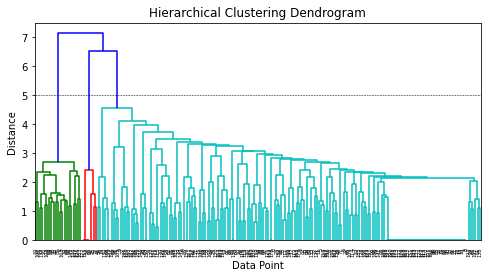

In [0]:
#Let's visualize the dendeogram
plt.figure (figsize = (8,4))
plt.title ('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=5,c='k',ls='--',lw=0.5);

In [0]:
#We hope to find 3 distinct clusters so we set our maximum distance between tweets to 5.
max_dist = 5
#we label our clusters to see where each tweet lands.
cluster_lables = fcluster(Z,max_dist, criterion='distance')
cluster_lables = pd.DataFrame(cluster_lables,columns=['ClusterLabel'])
output_df = pd.concat([df,cluster_lables],axis=1)
output_df.sample(n=20, random_state=6)

,tweet_text,Label,ClusterLabel
118,@sarahlou_iorua @mcdermott2309 Happy Sunday ev...,UAE,3
11,@TannerCurrie Alleges Excessive Force Used Whi...,Iran,3
149,"Trump blasts 'failed candidates' Jeb Bush, Lin...",Iran,1
152,Saada city suffers some of the worst destructi...,Iran,3
145,"@danielmarven Never mind, You are right. And g...",UAE,3
134,@TweedyStyles CIA predict third terrorist atta...,Iran,3
93,"Ashley Madison Our site is full of womsen, an...",Russia,3
19,Just get in and live your #dreams and your #su...,UAE,3
4,Running on empty: Russia has less than three d...,Iran,3
6,RT @Partisangirl: The #FakeNewsMedia is tellin...,Russia,3


In [0]:
#The number of concepts we hope to find.
lsa = TruncatedSVD (n_components=5, n_iter=100)
lsa.fit(similarity_df)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=100,
             random_state=None, tol=0.0)

In [0]:
terms = tv.get_feature_names()
terms[:10]

['almost',
 'amazing',
 'another',
 'anyone',
 'attack',
 'back',
 'beautiful',
 'ben',
 'best',
 'better']

In [0]:
#loop through different rows
for i,comp in enumerate(lsa.components_):#enumerate return index and row, a list of tuples
    componentTerms = zip(terms,comp) #we use zip to combine values and terms
    #sort component terms, by concept value,lambda x (x correpsnding tuples) and X[1] the value
    sortedTerms = sorted(componentTerms, key=lambda x:x[1], reverse=True) #descending order
    sortedTerms = sortedTerms[:10] #select 10 most imp. terms in a specific concept
    print ("\nConcept",i,":")
    for term in sortedTerms:
        print (term)


Concept 0 :
('security', 0.2620480178622817)
('another', 0.25195639127785774)
('get', 0.2509390560469545)
('offer', 0.22922531714316557)
('read', 0.21657225532487684)
('illegal', 0.21628455896558205)
('word', 0.20845879290606115)
('well', 0.2078238434478396)
('hard', 0.20661791515295586)
('minister', 0.205849652767954)

Concept 1 :
('life', 0.4196969943576492)
('mark', 0.4196969943576492)
('much', 0.272441021188948)
('history', 0.24326240874652444)
('security', 0.21557776465647022)
('intelligence', 0.16359533927536493)
('leader', 0.045310009964561596)
('love', 0.028354326707945965)
('kind', 0.005257052687848107)
('think', 0.0046878921407930265)

Concept 2 :
('middle', 0.4732031507046798)
('time', 0.40145292432410795)
('helping', 0.388370752568236)
('dont', 0.27359792044173165)
('mission', 0.11034130246064704)
('happy', 0.10313898393276306)
('back', 0.07490177809880896)
('border', 0.07490177809880896)
('right', 0.030388202310206374)
('running', 0.02811735429022022)

Concept 3 :
('right

In [0]:
concept_words = {} #create an empty dictionary

In [0]:
for i,comp in enumerate(lsa.components_):#enumerate return index and row, a list of tuples
    componentTerms = zip(terms,comp) #we use zip to combine values and terms
    #sort component terms, by concept value,lambda x (x correpsnding tuples) and X[1] the value
    sortedTerms = sorted(componentTerms, key=lambda x:x[1], reverse=True) #decending order
    sortedTerms = sortedTerms[:10] #select 10 most imp. terms in a specific concept
    concept_words["Concept " + str(i)] = sortedTerms #all concepts mapped with list of tuples

In [0]:
concept_words

{'Concept 0': [('security', 0.2620480178622817),
  ('another', 0.25195639127785774),
  ('get', 0.2509390560469545),
  ('offer', 0.22922531714316557),
  ('read', 0.21657225532487684),
  ('illegal', 0.21628455896558205),
  ('word', 0.20845879290606115),
  ('well', 0.2078238434478396),
  ('hard', 0.20661791515295586),
  ('minister', 0.205849652767954)],
 'Concept 1': [('life', 0.4196969943576492),
  ('mark', 0.4196969943576492),
  ('much', 0.272441021188948),
  ('history', 0.24326240874652444),
  ('security', 0.21557776465647022),
  ('intelligence', 0.16359533927536493),
  ('leader', 0.045310009964561596),
  ('love', 0.028354326707945965),
  ('kind', 0.005257052687848107),
  ('think', 0.0046878921407930265)],
 'Concept 2': [('middle', 0.4732031507046798),
  ('time', 0.40145292432410795),
  ('helping', 0.388370752568236),
  ('dont', 0.27359792044173165),
  ('mission', 0.11034130246064704),
  ('happy', 0.10313898393276306),
  ('back', 0.07490177809880896),
  ('border', 0.07490177809880896),